https://archive.ics.uci.edu/ml/datasets/wine+quality

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,GradientBoostingClassifier,StackingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

RANDOM_STATE = 42

## Выбраны маленькие диапазоны Поиска параметров из-за слабого ПК 

In [2]:
link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv('winequality-red.csv',sep=';')

y = data['quality']
X = data.drop('quality',axis=1)
#feature_cols = X.columns
#data

1.Оцените качество по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_STATE) 

clf_DTC = DecisionTreeClassifier().fit(X_train,y_train)
y_pred_DTC = clf_DTC.predict(X_test)
print("Accuracy_DTC:",metrics.accuracy_score(y_test, y_pred_DTC))

clf_BC = BaggingClassifier(base_estimator=SVC(), n_estimators=100, random_state=RANDOM_STATE).fit(X, y)
y_pred_BC = clf_BC.predict(X_test)
print("Accuracy_BC:",metrics.accuracy_score(y_test, y_pred_BC))

clf_RFC = RandomForestClassifier(max_depth=100, random_state=RANDOM_STATE).fit(X, y)
y_pred_RFC = clf_RFC.predict(X_test)
print("Accuracy_RFC:",metrics.accuracy_score(y_test, y_pred_RFC))

# # Для данного массива данных Классификация методом случайных деревьев наиболее выигрышна и позволяет добиться значительного показателя точности

Accuracy_DTC: 0.56875
Accuracy_BC: 0.495
Accuracy_RFC: 1.0


2.Разделите выборку на обучающую и тестовую в отношении 70%/30%

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE) 

3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:
    
10, 50, 100, 200, далее с шагом 200 до 5000 деревьев.
Постройте график зависимости качества от числа деревьев.



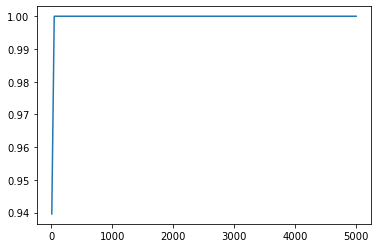

In [5]:
list_trees = [10, 50, 100] + [i+200 for i in range(0,5000,200)]
list_acc = []

for i in range(len(list_trees)): 
    clf_RFC = RandomForestClassifier(max_depth=list_trees[i], warm_start='true', random_state=RANDOM_STATE).fit(X, y)
    y_pred_RFC = clf_RFC.predict(X_test)
    list_acc.append(metrics.accuracy_score(y_test, y_pred_RFC))

plt.plot(list_trees, list_acc)

4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score

In [6]:
clf_GB = GradientBoostingClassifier().fit(X_train, y_train)
clf_XGB = XGBClassifier().fit(X_train, y_train)

n_scores_GB  = np.mean(cross_val_score(clf_GB, X, y))
n_scores_XGB = np.mean(cross_val_score(clf_XGB, X, y))
print('Точность GB : %f' % (n_scores_GB))
print('Точность XGB: %f' % (n_scores_XGB))

# X Градиентный бустинг показывает более точный результат

Точность GB : 0.560986
Точность XGB: 0.569099


5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3).
Параметры для оптимизации:

количество деревьев

глубина деревьев

оптимизируемый функционал

скорость обучения

Сравните значение метрики accuracy и скорость работы. Выведите лучшие параметры алгоритмов.

In [28]:
parametrs_GB = { 'n_estimators': range(60, 71, 10),
              'max_depth': range(6, 10, 2),
              'learning_rate': np.arange(0.1, 0.21, 0.1),
              #'loss': ['deviance','exponential'] 
               }

grid_GB = GridSearchCV(clf_GB, parametrs_GB, cv=3,n_jobs = -1).fit(X_train, y_train)

In [7]:
parametrs_XGB = { 'n_estimators': range(60, 71, 10),
              'max_depth': range(8, 11, 2),
              'learning_rate': np.arange(0.1, 0.21, 0.1),
              'loss': ['log_loss', 'deviance', 'exponential'] }

grid_XGB = GridSearchCV(clf_XGB, parametrs_XGB, cv=3,n_jobs = -1).fit(X_train, y_train)

In [29]:
#pd.DataFrame(grid_GB.cv_results_)
mean_test_score_GB= np.mean(grid_GB.cv_results_['mean_test_score'])
mean_score_time_GB= np.mean(grid_GB.cv_results_['mean_score_time'])

mean_test_score_XGB= np.mean(grid_XGB.cv_results_['mean_test_score'])
mean_score_time_XGB= np.mean(grid_XGB.cv_results_['mean_score_time'])

print('Среднее время    XGB  %f' % mean_score_time_XGB)
print('Среднее время    GB   %f' % mean_score_time_GB)
print('Средная точность XGB  %f' % mean_test_score_XGB)
print('Средная точность GB   %f' % mean_test_score_GB)

print(grid_XGB.best_params_)
print(grid_GB.best_params_)

# XBoosting показывает выше точности, а обычный GradientBoosting меньше скорость обработки элементов выборки

Среднее время    XGB  0.015324
Среднее время    GB   0.012026
Средная точность XGB  0.628239
Средная точность GB   0.633601
{'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 10, 'n_estimators': 70}
{'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 60}


6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.

In [ ]:
%%capture

clf_LGBM = LGBMClassifier().fit(X_train, y_train)
clf_CB = CatBoostClassifier().fit(X_train, y_train)

n_scores_LGBM = np.mean(cross_val_score(clf_LGBM, X, y))
n_scores_CB = np.mean(cross_val_score(clf_CB, X, y))

In [10]:
print('Точность LGBM: %f' % (n_scores_LGBM))
print('Точность CB:   %f' % (n_scores_CB))
print('Точность GB:   %f' % (n_scores_GB))
print('Точность XGB:  %f' % (n_scores_XGB))

# Наиболее высокий показатель точности у XGBoost

Точность LGBM: 0.557247
Точность CB:   0.545976
Точность GB:   0.560986
Точность XGB:  0.569099


7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями. Выведите лучшие параметры алгоритмов.
Сравните значение метрики accuracy и скорость по этим четырем реализациям.

In [17]:
parametrs_LGBM = { 'n_estimators': range(60, 71, 10),
              'max_depth': range(6, 11, 2),
              'learning_rate': np.arange(0.1, 0.21, 0.1),
              'objective': ['regression', 'regression_l1', 'huber', 'fair'] }

grid_LGBM = GridSearchCV(clf_LGBM, parametrs_LGBM, cv=3,n_jobs = -1).fit(X_train, y_train)

In [ ]:
parametrs_CB = { 'n_estimators': range(30, 51, 10),
              'max_depth': range(6, 11, 2),
              'learning_rate': np.arange(0.1, 0.21, 0.1) 
               }

grid_CB = GridSearchCV(clf_CB, parametrs_CB, cv=3,n_jobs = -1).fit(X_train, y_train)

In [30]:
#pd.DataFrame(grid_GB.cv_results_)

mean_test_score_LGBM= np.mean(grid_LGBM.cv_results_['mean_test_score'])
mean_score_time_LGBM= np.mean(grid_LGBM.cv_results_['mean_score_time'])

mean_test_score_CB= np.mean(grid_CB.cv_results_['mean_test_score'])
mean_score_time_CB= np.mean(grid_CB.cv_results_['mean_score_time'])

print('Среднее время    XGB  %f' % mean_score_time_XGB)
print('Среднее время    GB   %f' % mean_score_time_GB)
print('Среднее время    LGBM %f' % mean_score_time_LGBM)
print('Среднее время    CB   %f' % mean_score_time_CB)

print('Средная точность XGB  %f' % mean_test_score_XGB)
print('Средная точность GB   %f' % mean_test_score_GB)
print('Средная точность LGBM %f' % mean_test_score_LGBM)
print('Средная точность CB   %f' % mean_test_score_CB)

# Обычный GradientBoosting выиграет миллисекунды, и GradientBoosting показывает выше точнссть
print(grid_XGB.best_params_)
print(grid_GB.best_params_)
print(grid_LGBM.best_params_)
print(grid_CB.best_params_)

Среднее время    XGB  0.015324
Среднее время    GB   0.012026
Среднее время    LGBM 0.018228
Среднее время    CB   0.018813
Средная точность XGB  0.628239
Средная точность GB   0.633601
Средная точность LGBM 0.615505
Средная точность CB   0.623842
{'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 10, 'n_estimators': 70}
{'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 60}
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 60, 'objective': 'regression'}
{'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 30}


8.Подберите оптимальные параметры алгоритма из библиотеки xgbost с помощью [hyperopt](https://github.com/hyperopt/hyperopt) . Параметры для оптимизации:

оптимизируемый функционал

скорость обучения

количество деревьев

глубина деревьев

Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.

In [64]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    current_score = cross_val_score(clf, X, y, cv=3).mean()
    return -current_score

space_xgb = {
            'n_estimators': hp.choice('n_estimators',     range(1, 51, 1)),
            'learning_rate':hp.uniform('learning_rate',0.1, 0.91),
            'max_depth':    hp.choice('max_depth',        range(1, 51, 1)),
        }

best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)

print(best)
print(grid_XGB.best_params_)

# HyperOpt параметры показывают более точные(меньшие) значения, требуется дополнительная проверка выданных параметров

100%|██████████| 10/10 [00:04<00:00,  2.15trial/s, best loss: -0.5547217010631645]
{'learning_rate': 0.4452902060672219, 'max_depth': 3, 'n_estimators': 16}
{'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 10, 'n_estimators': 70}


9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.

In [ ]:
estimators = [
    ('GB', clf_GB),
    ('XGB', clf_XGB),
    ('LGBM', clf_LGBM),
    ('CB', clf_CB),
]

clf_Stack = StackingClassifier(
    estimators=estimators, n_jobs=-1,verbose='False')

clf_Stack.fit(X_train, y_train)

In [33]:
print(clf_Stack.score(X_test, y_test))

0.6625


10.Выведите качество по метрике accuracy стэкинга 4-х алгоритмов с оптимальными параметрами градиентного бустинга. Сравните результаты с предыдущим шагом и напишите какой вывод можно из этого сделать.

In [ ]:
clf_XGB_updated = XGBClassifier(**grid_XGB.best_params_).fit(X_train, y_train)

estimators = [
    ('GB', clf_GB),
    ('XGB', clf_XGB_updated),
    ('LGBM', clf_LGBM),
    ('CB', clf_CB),
]

clf_Stack_updated = StackingClassifier(
    estimators=estimators, n_jobs=-1)

clf_Stack_updated.fit(X_train, y_train)

In [35]:
print(clf_Stack_updated.score(X_test, y_test))

# Для текущего набора данных целесообразно использовать оптимальные параметры 
# одного из 4 классификатора внутри Совместного классификатора, т.к. точность увеличивается

0.6666666666666666
